# Pima-indian 당뇨병 데이터 예측

1. 결과를 submission.csv 에 학습 라벨 병합해 제출
1. 강사가 각 팀별 제출 submission.csv 를 accuracy 점수로 평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

### Data

- Pregnancies : 임신횟수
- Glucose : 포도당 농도
- BloodPressure : 혈압
- SkinThickness : 피부 두께
- Insulin : 인슐린
- BMI : 체질량지수
- DiabetesPedigreeFunction : 당뇨병 혈통 기능
- Age : 나이
- Outcome : 당뇨병 여부(0: 발병되지 않음, 1: 발병)

In [3]:
train = read_csv('1.diabetes_train.csv')
test = read_csv('2.diabetes_test.csv')
submission = read_csv('3.diabetes_submission.csv')

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient_ID                652 non-null    object 
 1   Pregnancies               652 non-null    int64  
 2   Glucose                   652 non-null    int64  
 3   BloodPressure             652 non-null    int64  
 4   SkinThickness             652 non-null    int64  
 5   Insulin                   652 non-null    int64  
 6   BMI                       652 non-null    float64
 7   DiabetesPedigreeFunction  652 non-null    float64
 8   Age                       652 non-null    int64  
 9   Outcome                   652 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 51.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ---

In [4]:
train.isnull().sum()

Patient_ID                  0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<Axes: >

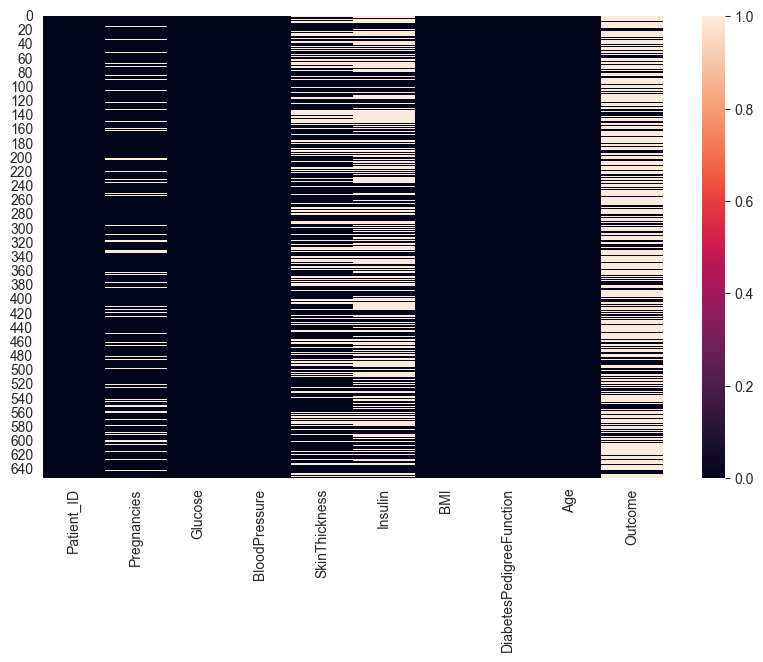

In [26]:
# isnull().sum()으로 확인했을 때 결측치가 없었으나 0으로 처리된 것들이 있었으므로,
# 0을 결측치로 간주하고 확인
train_zero = train.replace(0, np.nan)

# 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(train_zero.isnull())
# plt.show(train_zero)

In [6]:
train_zero.isna().sum()

Patient_ID                    0
Pregnancies                  93
Glucose                       4
BloodPressure                33
SkinThickness               193
Insulin                     316
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     423
dtype: int64

In [7]:
# Pregnancies와 Outcome은 0이 결측치가 아니므로 무시.
# Glucose, BloodPressure, SkinThickness, Insulin, BMI만 처리해주면 될 듯 하다.

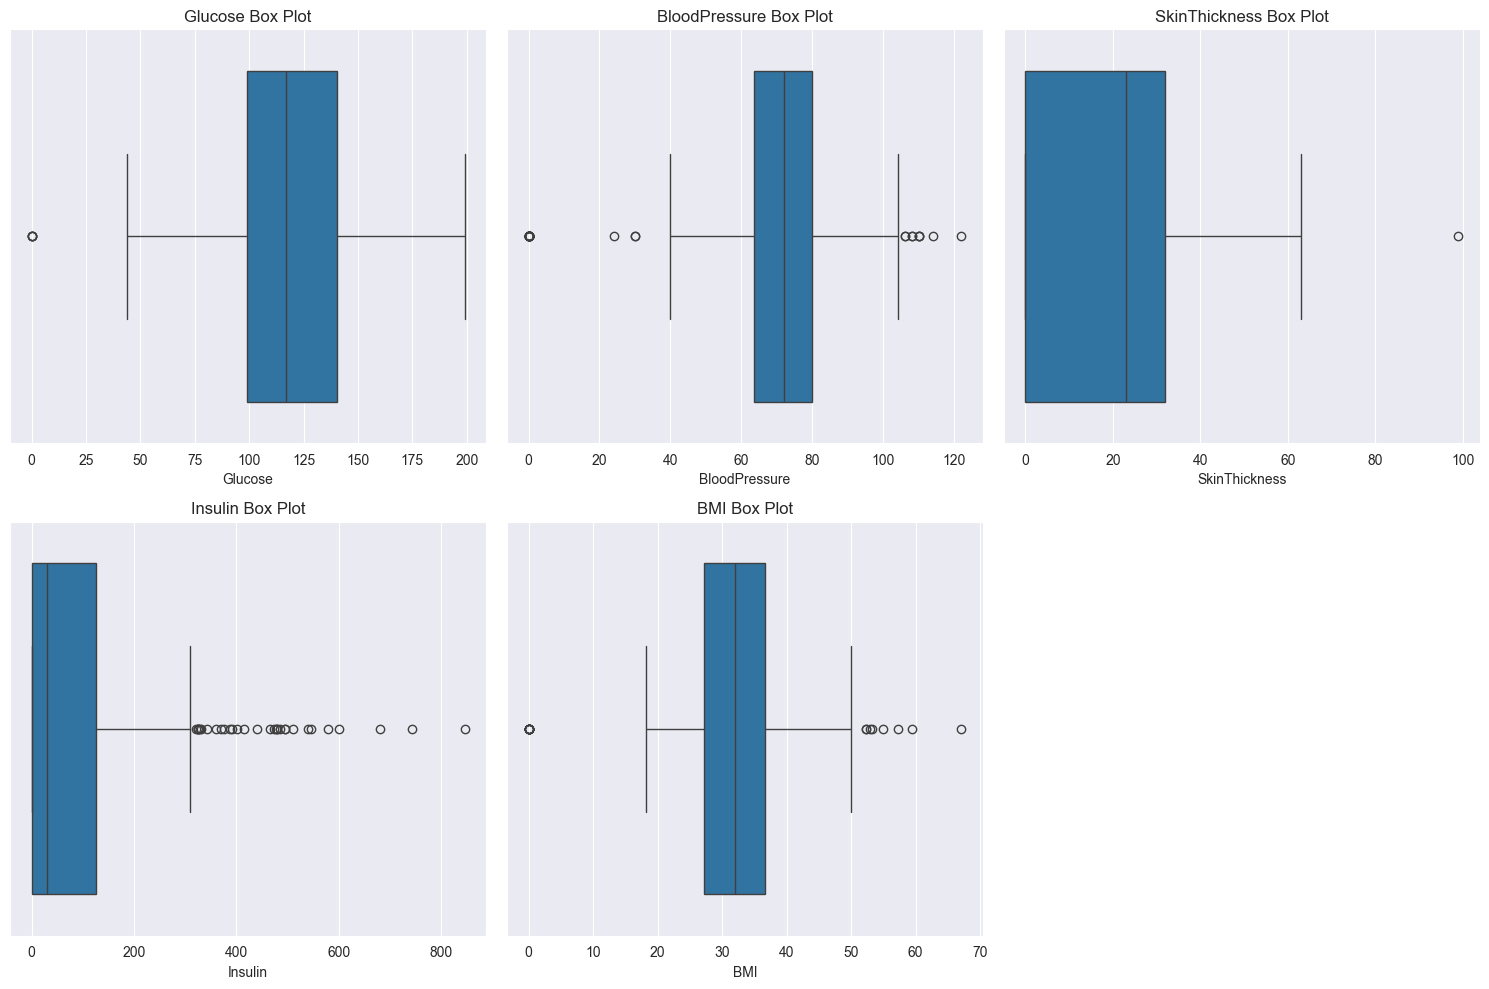

In [8]:
# 박스플롯을 이용한 이상치 확인
plt.figure(figsize=(15, 10))

for i, column in enumerate(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=train[column])
    plt.title(f'{column} Box Plot')

plt.tight_layout()
plt.show()

In [9]:
# Glucose, BloodPressure, SkinThickness, Insulin, BMI에 이상치도 존재한다.

# 공복일 때 인슐린 수치가 0일 수도 있다는 정보를 찾아, 인슐린은 0을 결측치로 처리하면 안될듯.
# 300부터 이상치로 잡히는데, 당뇨 환자의 경우 600까지도 잡히므로 수치가 많이 잡히는 500까지는 이상치로 처리하면 안될듯.
insulin = train['Insulin'].median()
train.loc[train['Insulin'] >= 500, 'Insulin'] = insulin
test.loc[test['Insulin'] >= 500, 'Insulin'] = insulin

# BMI는 50 이상이려면 170cm에 150kg이상이여야한다.
# 실제 데이터일 수 있지만 예외적 케이스이므로 이상치 처리해주는게 맞을듯.
bmi = train['BMI'].median()
train.loc[(train['BMI'] == 0) | (train['BMI'] >= 50), 'BMI'] = bmi
test.loc[(test['BMI'] == 0) | (test['BMI'] >= 50), 'BMI'] = bmi

# BloodPressure은 저혈압, 고혈압이 이상치로 잡힌 듯 하다.
# 당뇨에 영향이 있을 수 있으므로 0만 이상치라고 판단.
bloodpressure = train['BloodPressure'].median()
train.loc[train['BloodPressure'] == 0, 'BloodPressure'] = bloodpressure
test.loc[test['BloodPressure'] == 0, 'BloodPressure'] = bloodpressure

# Glucose는... 0일수가 있나? 값도 적고 Outcome도 달라서 이상치로 간주
glucose = train['Glucose'].median()
train.loc[train['Glucose'] == 0, 'Glucose'] = glucose
test.loc[test['Glucose'] == 0, 'Glucose'] = glucose


/var/folders/x_/xf7w4xhx6kl03__yxdgdfl9m0000gn/T/ipykernel_77458/831496475.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train['Insulin'] >= 500, 'Insulin'] = insulin
/var/folders/x_/xf7w4xhx6kl03__yxdgdfl9m0000gn/T/ipykernel_77458/831496475.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.loc[test['Insulin'] >= 500, 'Insulin'] = insulin


In [10]:
# SkinThickness가 90이상인 이상치가 99로 되어있다.
# 대충 직감으로 9의 오타라고 생각하고 9로 바꿔주자.
skin90 = train[train['SkinThickness'] >= 90]
skin90

,Patient_ID,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
435,Patient_580,2,197,70,99,0.0,34.7,0.575,62,1


In [11]:
train.loc[train['SkinThickness'] >= 99, 'SkinThickness'] = 0
test.loc[test['SkinThickness'] >= 99, 'SkinThickness'] = 0

skin90 = train[train['SkinThickness'] >= 90]
print (skin90) #잘 처리됐음

Empty DataFrame
Columns: [Patient_ID, Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


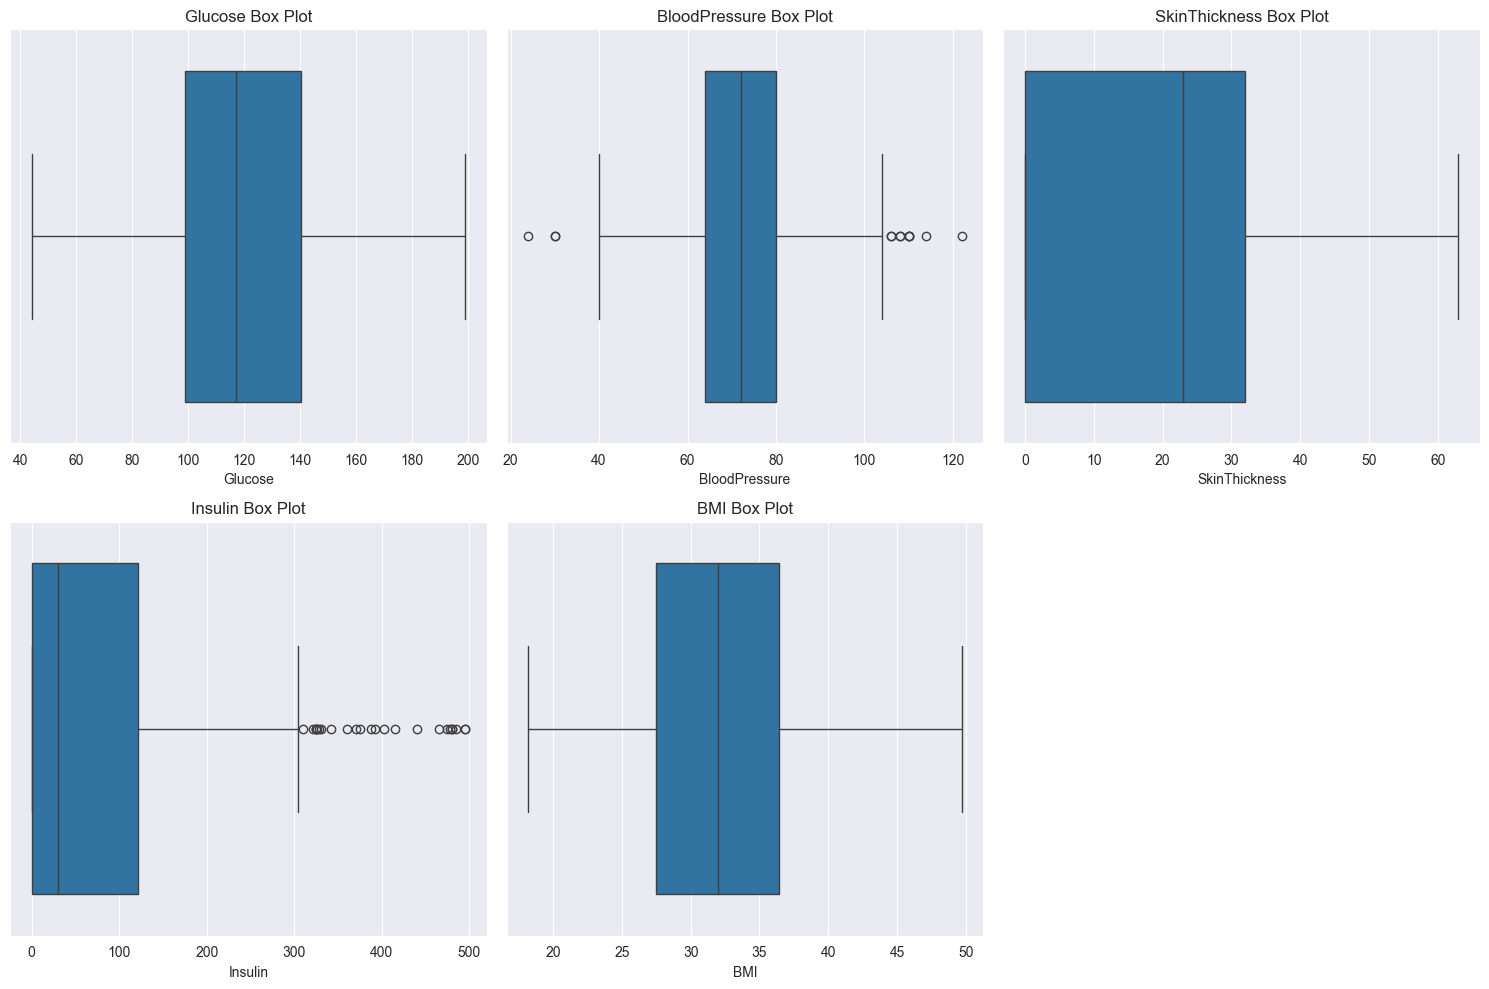

In [12]:
# 다시 확인. 만약 결과가 이상하면 그 때 이상치를 다 없애는걸로...
# + 4차 : 이상치를 모두 제거해봤는데 점수가 더 낮아진다. 이걸로 유지.

plt.figure(figsize=(15, 10))

for i, column in enumerate(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=train[column])
    plt.title(f'{column} Box Plot')

plt.tight_layout()
plt.show()

In [13]:
# feature와 target 분리
X = train.drop(['Patient_ID','Outcome'], axis=1)
y = train['Outcome']
X_test = test.drop(['Patient_ID'], axis=1) # no label, only prediction용

In [14]:
# 데이터 분할

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=50)

In [15]:
# 스케일러
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [16]:
# xgboost 학습
xgb_clf = XGBClassifier(max_depth=3, random_state=50)

In [17]:
# 5-Fold CV
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(xgb_clf, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation :", np.mean(cross_val_scores))

xgb_clf.fit(X_train_scaled, y_train)


Cross-validation scores: [0.81521739 0.65934066 0.76923077 0.79120879 0.73626374]
Mean cross-validation : 0.7542522694696607


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [18]:
y_pred = xgb_clf.predict(X_val_scaled)

In [19]:
# classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       132
           1       0.59      0.66      0.62        64

    accuracy                           0.74       196
   macro avg       0.71      0.72      0.71       196
weighted avg       0.75      0.74      0.74       196



In [20]:
# 최종 테스트 데이터 예측 및 저장
pred_test = xgb_clf.predict(X_test_scaled)

In [21]:
submission['Outcome'] = pred_test
submission.head()

,Patient_ID,Outcome
0,Patient_227,0
1,Patient_611,0
2,Patient_506,0
3,Patient_471,0
4,Patient_475,0


In [22]:
submission.to_csv('submission.csv', index=False)

### Submission 점수 확인

- 실제 사이트에 제출하는 것 처럼
- 제출한 `submission.csv` 를 정답 레이블 데이터와 accuracy 평가